In [3]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import phate
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scprep
import torch
from torch import nn, optim

import sys
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(project_root, 'src'))

import src.data_loader as dataloader
from src.data_loader import load_data_1000G, load_data_HGDP
import src.mappings as mappings
from src.train_AE import DenoisingAutoencoder
from src.preprocess import maf_scale
from src.mappings import make_palette_label_order_HGDP

from dotenv import load_dotenv
dotenv_path = os.path.join(project_root, '.env')

import AAnet_torch.utils as utils
import AAnet_torch.models as models

In [2]:
# Load environment variables
path = load_dotenv(dotenv_path)
PROJECT_PATH = os.getenv('PROJECT_PATH')
SCRATCH_PATH = os.getenv('SCRATCH_PATH')
SAVE_PATH = os.getenv('SAVE_PATH')
Figure_PATH = os.getenv('Figure_PATH')

In [3]:
data_name = '1KGP' # 'HGDP' 

# import data
# load data from original
if data_name == '1KGP':    
    DATA_PATH = SCRATCH_PATH + '1KGP/V3/'
    fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
    data, class_labels, samples, snp_names, class_label_names = load_data_1000G(os.path.join(DATA_PATH, fname))
    # get labels
    label_pop, label_superpop = dataloader.preprocess_labels_1000G(class_labels, class_label_names)
    cmap_pop = mappings.pop_pallette_1000G_fine
    cmap_superpop = mappings.pop_pallette_1000G_coarse
elif data_name == 'HGDP':
    DATA_PATH = SCRATCH_PATH + 'HGDP+1KGP/'
    fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet.hdf5'
    metadata_file = 'labels.tsv'
    unrelated_sampleid_1000G_path = DATA_PATH + '1000G_unrelated_samples_set_2504.txt'
    data_path = os.path.join(DATA_PATH, fname)
    metadata_path = os.path.join(DATA_PATH, metadata_file)
    data, class_labels, samples, snp_names, class_label_names, metadata_labels = load_data_HGDP(data_path, metadata_path, unrelated_sampleid_1000G_path)

    # get labels
    cmap_superpop, cmap_pop, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(metadata_labels)
    label_superpop = metadata_labels['Superpopulation'].values
    label_pop = metadata_labels['Population'].values


# 100D AE + PHATE

In [4]:
# normalize data for AE
maf_scaled_data = maf_scale(data)
data_tensor = torch.from_numpy(maf_scaled_data).float()
input_dim = data.shape[1]

In [7]:
# trained model path
if data_name == '1KGP':  
    model_save_path = SAVE_PATH + 'AE/ae_trained_model_750.pth'
elif data_name == 'HGDP':
    model_save_path = SAVE_PATH + 'AE/ae_trained_model_HGDP_1.pth'


# Initialize the model
latent_dim = 100  # Latent space dimension
model = DenoisingAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Load the trained model's weights
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

# Assuming `data` is your input tensor, move it to the correct device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data_tensor.to(device)  # Move data to device

# Use the encoder for inference (dimensionality reduction)
with torch.no_grad():  # Disable gradient computation for inference
    reduced_data = model.encoder(data)

reduced_data_np = reduced_data.cpu().numpy()
reduced_data_np_norm = reduced_data_np / np.std(reduced_data_np[:, 0])

In [6]:
# save for next time load
# df = pd.DataFrame(reduced_data_np)
# df.index = samples
# df.to_csv('/home/mila/s/shuang.ni/phate_genetics/data/1000G/1000G_AE.csv')

In [5]:
# Load saved latent space
reduced_data = pd.read_csv('/home/mila/s/shuang.ni/phate_genetics/data/1000G/1000G_AE.csv', index_col=0)
reduced_data_np = reduced_data.to_numpy() 
reduced_data_np_norm = reduced_data_np / np.std(reduced_data_np[:, 0])

In [6]:
# initial phate embedding
phate_operator_2d = phate.PHATE(random_state=42, 
                                n_components=2, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_2d.fit(reduced_data_np_norm)
phate_emb_2d = phate_operator_2d.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.94 seconds.
  Calculating affinities...
  Calculated affinities in 0.11 seconds.
Calculated graph and diffusion operator in 1.06 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.77 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.43 seconds.
Calculated landmark operator in 5.41 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.51 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.71 seconds.


<Axes: title={'center': '1KGP superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

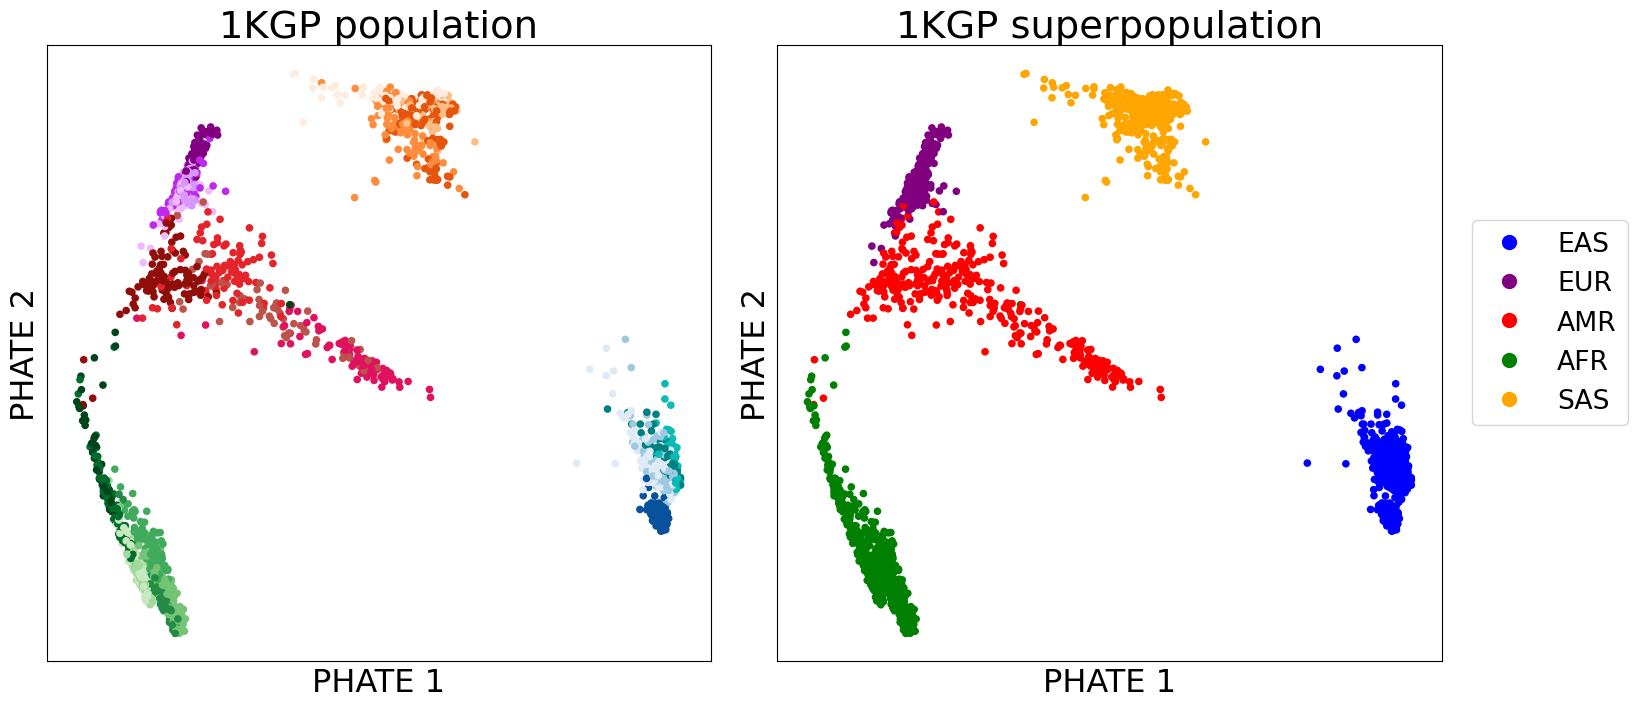

In [9]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap=cmap_pop, c=label_pop,
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title=data_name+' population', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap=cmap_superpop, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title=data_name+' superpopulation', fontsize=16)

# ADMIXTURE

In [7]:
admix = np.loadtxt(DATA_PATH+ 'ADMIXTURE/1000G_k5.txt')
print(admix[:,1])

[1.0457e-02 8.8150e-03 1.9370e-02 ... 5.6680e-03 2.8630e-03 1.0000e-05]


<Axes: title={'center': '1000G superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

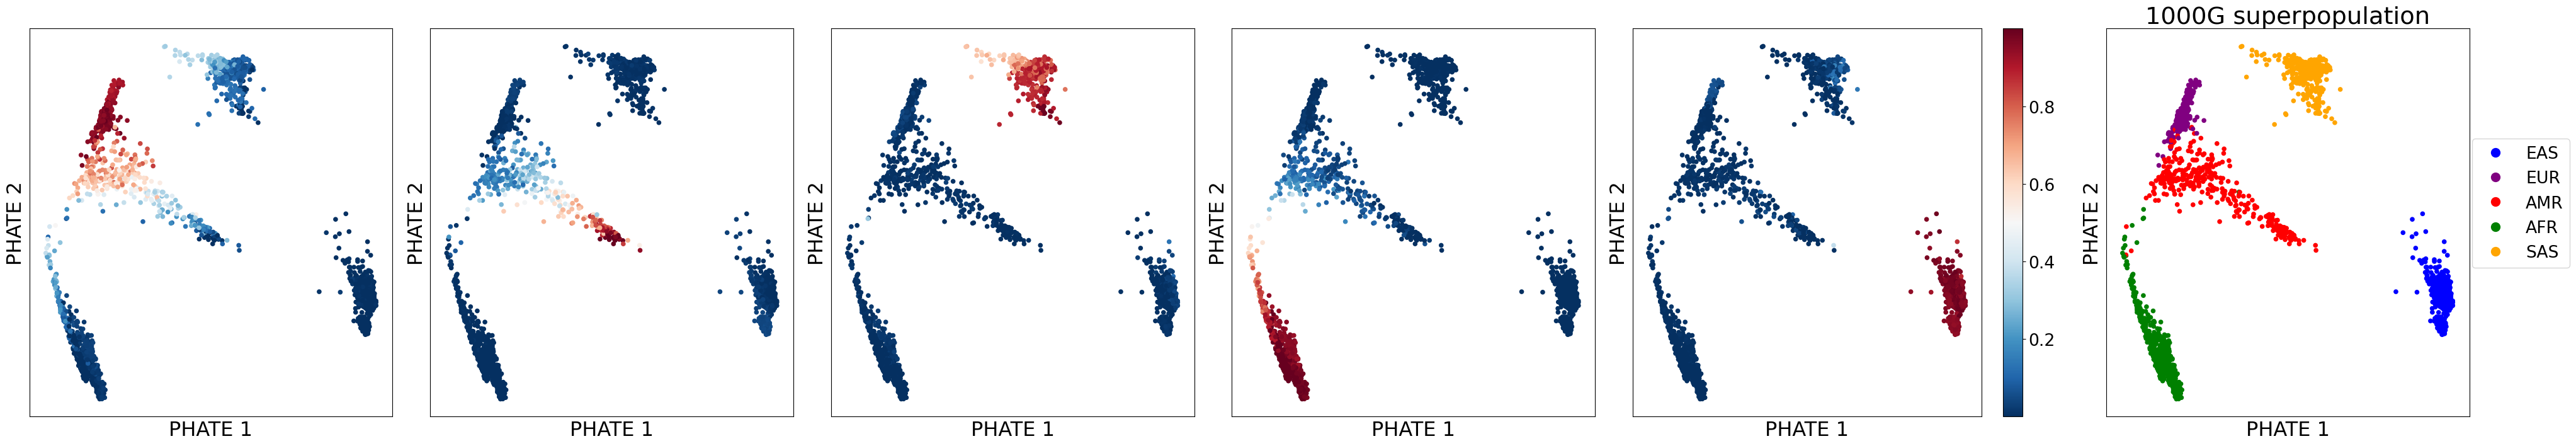

In [23]:
fig, axes = plt.subplots(1,6, figsize=(50, 8), gridspec_kw={'width_ratios': [1, 1,1,1,1.2, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap='RdBu_r', c=admix[:,0],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap='RdBu_r', c=admix[:,1],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[2],
                      cmap='RdBu_r', c=admix[:,2],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[3],
                      cmap='RdBu_r', c=admix[:,3],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[4],
                      cmap='RdBu_r', c=admix[:,4],
                      xticks=False, yticks=False, legend=True,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[5],
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)

In [73]:
admix = np.loadtxt(DATA_PATH+ 'ADMIXTURE/1000G_k4.txt')
print(admix[:,1])

[0.095007 0.097399 0.089246 ... 0.8722   0.890114 0.885335]


<Axes: title={'center': '1000G superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

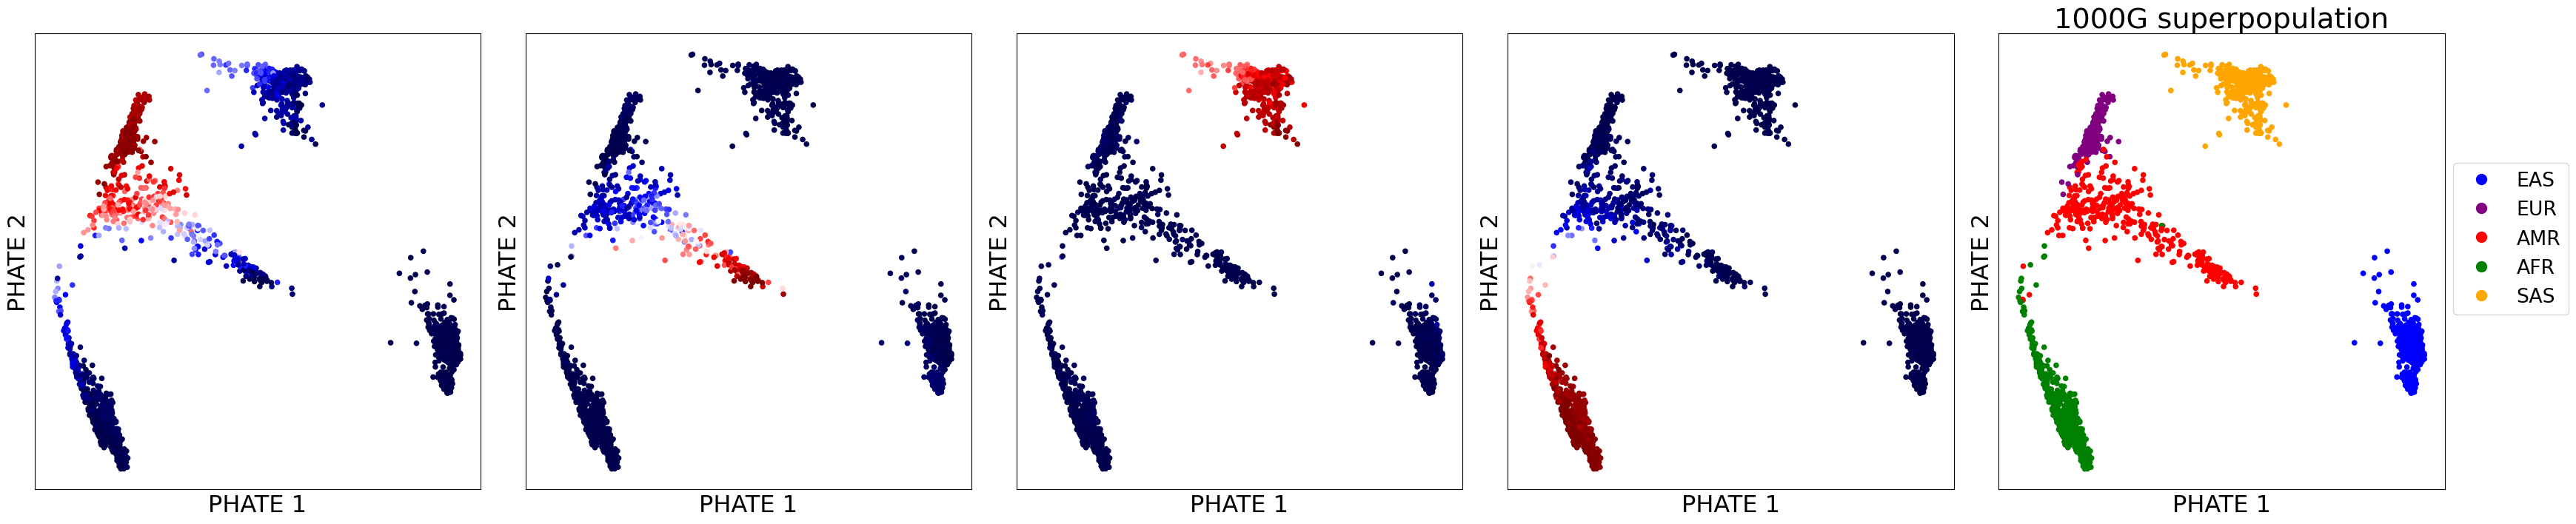

In [16]:
fig, axes = plt.subplots(1,5, figsize=(42, 8), gridspec_kw={'width_ratios': [1, 1,1,1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap='seismic', c=admix[:,0],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap='seismic', c=admix[:,1],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[2],
                      cmap='seismic', c=admix[:,2],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[3],
                      cmap='seismic', c=admix[:,3],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[4],
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)

# 100D AE + AAnet

In [ ]:
# density subsampling, no need if maximas are good
# distances, _ = sklearn.neighbors.NearestNeighbors(n_neighbors=2000).fit(reduced_data_np_norm).kneighbors()
# distances = distances.max(axis=1)
# p = distances / distances.sum()
# X_subsample = scprep.select.select_rows(reduced_data_np_norm, idx=np.random.choice(reduced_data_np_norm.shape[0],
#                                                                 int(reduced_data_np_norm.shape[0]/2), p=p, replace=False))


In [8]:
# Optionally, warm-start model with graph-based extrema
if data_name == '1KGP':
    N_ARCHETYPES = 5
elif data_name == 'HGDP':
    N_ARCHETYPES = 7

extrema_idx = torch.Tensor(utils.get_laplacian_extrema(reduced_data_np_norm, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(reduced_data_np_norm[extrema_idx.numpy().astype(int)])

<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


<Axes: title={'center': '1KGP superpopulation\n (with extrema)'}, xlabel='PHATE 1', ylabel='PHATE 2'>

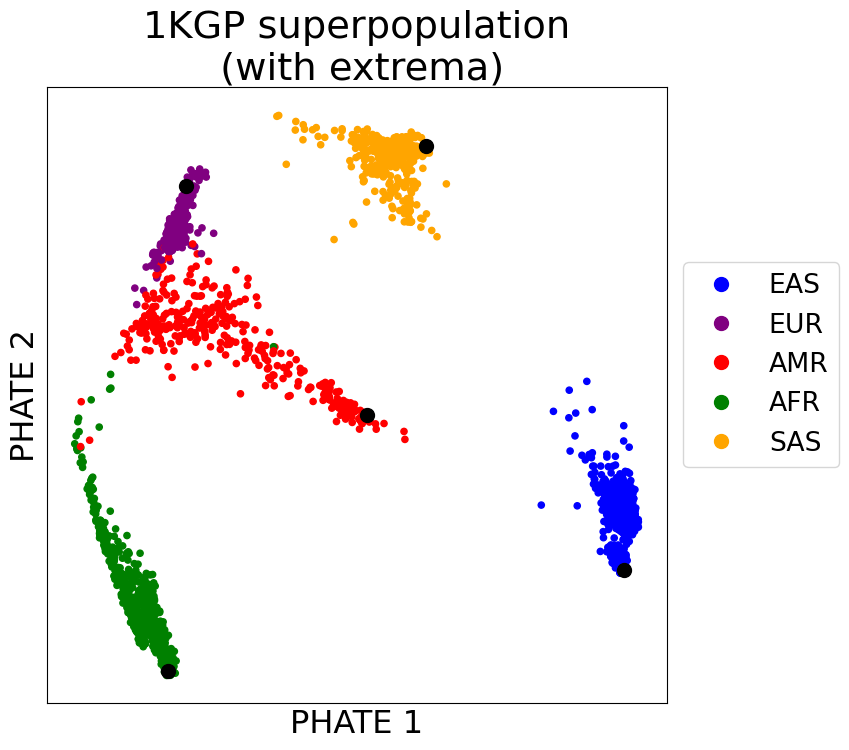

In [13]:
# visualize the extrema
if data_name == '1KGP':
    cmap = mappings.pop_pallette_1000G_coarse
    title = ' superpopulation'
elif data_name == 'HGDP':
    cmap = cmap_superpop
    title = ' superpopulation'

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=ax,
                      cmap=cmap, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title=data_name + title + '\n (with extrema)', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d[extrema_idx.numpy().astype(int)], s=100, c='black', ax=ax)

In [14]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
data_loader = torch.utils.data.DataLoader(reduced_data_np_norm, batch_size=256, shuffle=True, num_workers=4)
model = models.AAnet_vanilla(noise=0.01, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=reduced_data_np_norm.shape[1],
                             device=device, diffusion_extrema=extrema).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [14]:
# gamma_extrema parameter weights how informative graph-based extrema are to model
# higher gamma_extrema = more pushing AAnet to learn the archetypes learned from the graph-based approach
for i in range(300):
    loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=100)
    title='Epoch {}: R={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)
    print(title)

Epoch 0: R=0.89 A:0.00
Epoch 1: R=0.82 A:0.00
Epoch 2: R=0.78 A:0.00
Epoch 3: R=0.75 A:0.00
Epoch 4: R=0.72 A:0.00
Epoch 5: R=0.67 A:0.01
Epoch 6: R=0.62 A:0.01
Epoch 7: R=0.57 A:0.01
Epoch 8: R=0.54 A:0.01
Epoch 9: R=0.52 A:0.00
Epoch 10: R=0.51 A:0.00
Epoch 11: R=0.50 A:0.00
Epoch 12: R=0.49 A:0.00
Epoch 13: R=0.48 A:0.00
Epoch 14: R=0.48 A:0.00
Epoch 15: R=0.48 A:0.00
Epoch 16: R=0.48 A:0.00
Epoch 17: R=0.48 A:0.00
Epoch 18: R=0.47 A:0.00
Epoch 19: R=0.47 A:0.00
Epoch 20: R=0.47 A:0.00
Epoch 21: R=0.47 A:0.00
Epoch 22: R=0.47 A:0.00
Epoch 23: R=0.46 A:0.00
Epoch 24: R=0.46 A:0.00
Epoch 25: R=0.46 A:0.00
Epoch 26: R=0.46 A:0.00
Epoch 27: R=0.45 A:0.00
Epoch 28: R=0.45 A:0.00
Epoch 29: R=0.45 A:0.00
Epoch 30: R=0.45 A:0.00
Epoch 31: R=0.45 A:0.00
Epoch 32: R=0.45 A:0.00
Epoch 33: R=0.44 A:0.00
Epoch 34: R=0.44 A:0.00
Epoch 35: R=0.44 A:0.00
Epoch 36: R=0.44 A:0.00
Epoch 37: R=0.44 A:0.00
Epoch 38: R=0.44 A:0.00
Epoch 39: R=0.43 A:0.00
Epoch 40: R=0.43 A:0.00
Epoch 41: R=0.43 A:0.00
Ep

In [ ]:
if data_name == '1KGP':
    torch.save(model, SCRATCH_PATH + '1KGP/V3/'+'1000G_AAnet_model_gamma100.pth')
elif data_name == 'HGDP':
    torch.save(model, SCRATCH_PATH + 'HGDP+1KGP/AAnet/'+'HGDP_AAnet_model_gamma100.pth')


In [9]:
# load model from saved
if data_name == '1KGP':
    model = torch.load(SCRATCH_PATH + '1KGP/V3/'+'1000G_AAnet_model_gamma100.pth')

In [10]:
archetypal_embedding = model.encode(torch.Tensor(reduced_data_np_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
aanet_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
aanet_ats_phate = phate_operator_2d.transform(aanet_ats)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


<Axes: title={'center': '1KGP superpopulation\n (with archetypal)'}, xlabel='PHATE 1', ylabel='PHATE 2'>

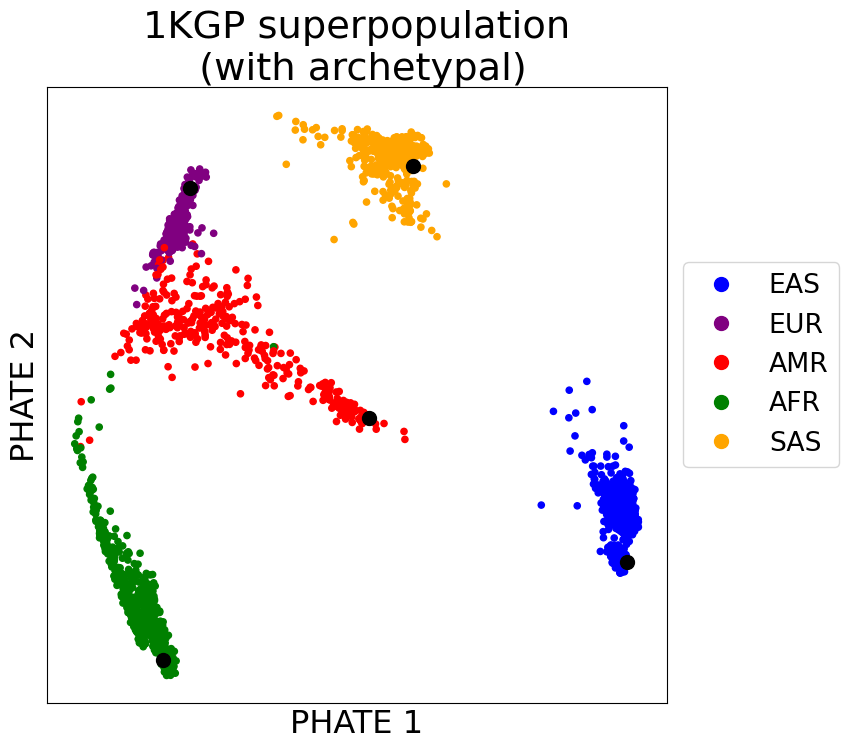

In [12]:
# visualize the aanet_ats_phate
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=ax,
                      cmap=cmap_superpop, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title=data_name + ' superpopulation' + "\n (with archetypal)", fontsize=16)
scprep.plot.scatter2d(aanet_ats_phate, s=100, c='black', ax=ax)

In [19]:
# Step 1: Shift the array to make all values positive
shifted_arr = barycentric_archetypal_embedding - barycentric_archetypal_embedding.min(axis=1, keepdims=True)

# Step 2: Normalize each row to represent percentages (i.e., the sum equals 1)
normalized_log_arr = shifted_arr / shifted_arr.sum(axis=1, keepdims=True)
new_order = [3, 4, 2, 1, 0]
normalized_log_arr_reorder = normalized_log_arr[:, new_order]

<Axes: title={'center': '1000G superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

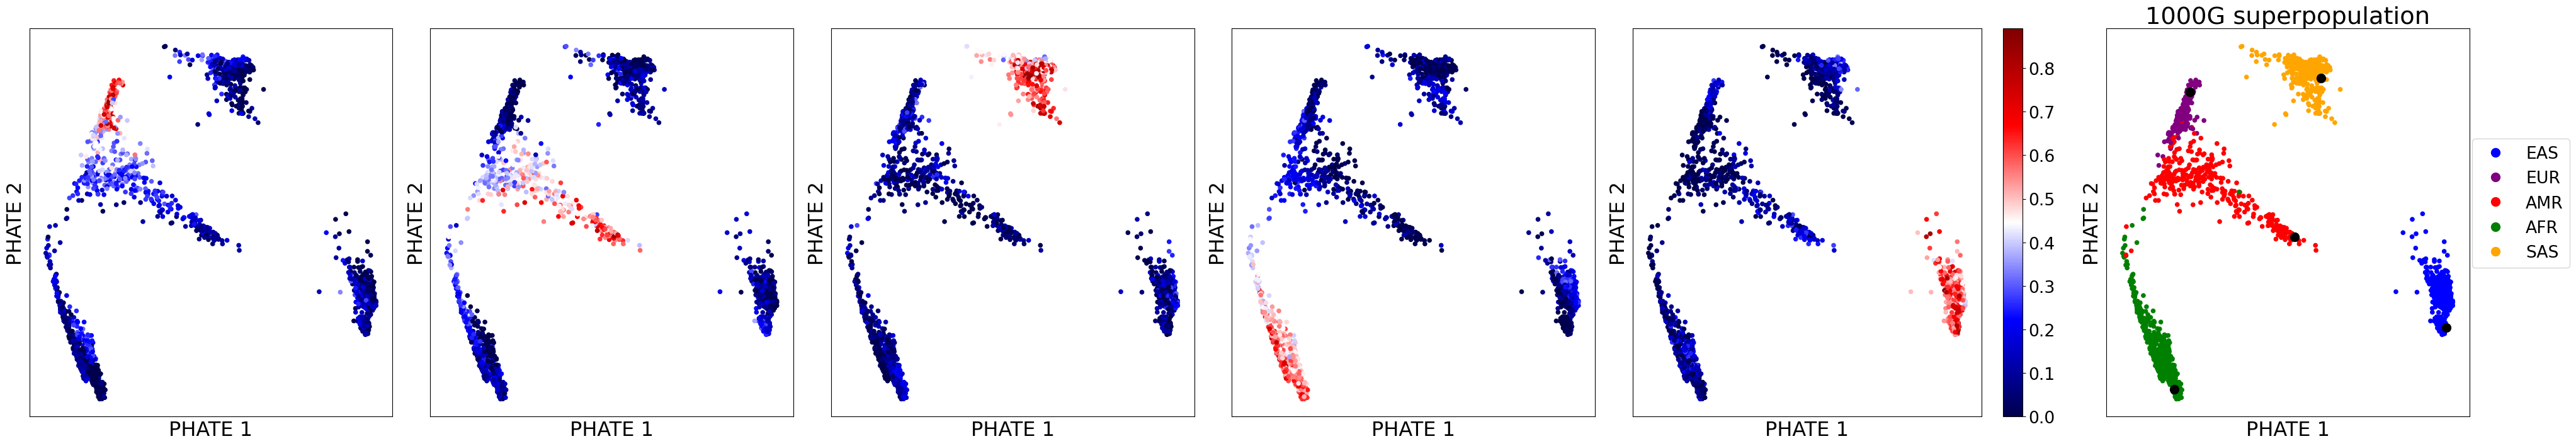

In [22]:
fig, axes = plt.subplots(1,6, figsize=(50, 8), gridspec_kw={'width_ratios': [1, 1,1,1,1.2, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap='seismic', c=normalized_log_arr_reorder[:,0],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap='seismic', c=normalized_log_arr_reorder[:,1],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[2],
                      cmap='seismic', c=normalized_log_arr_reorder[:,2],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[3],
                      cmap='seismic', c=normalized_log_arr_reorder[:,3],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[4],
                      cmap='seismic', c=normalized_log_arr_reorder[:,4],
                      xticks=False, yticks=False, legend=True,
                      label_prefix="PHATE ", fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[5],
                      cmap=cmap_superpop, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)
scprep.plot.scatter2d(aanet_ats_phate,
                        c='black', ax=axes[5], s=100)

In [ ]:
#save df
normalized_log_arr_df = pd.DataFrame(normalized_log_arr_reorder, index=samples)
normalized_log_arr_df.columns = ['EUR', 'AMR', 'SAS', 'AFR', 'EAS']

if data_name == '1KGP':
    normalized_log_arr_df.to_csv(SCRATCH_PATH + '1KGP/V3/'+'1000G_AAnet_archetypal_affinity.csv')

# correlation between archetypal_affinity and admixture

In [29]:

admix = np.loadtxt(DATA_PATH+ 'ADMIXTURE/1000G_k5.txt')
admix = admix[:,0:5]
admix_df = pd.DataFrame(admix, index=samples)
admix_df.columns = ['EUR', 'AMR', 'SAS', 'AFR', 'EAS']

# Calculate correlation for each corresponding column
correlations = {col: admix_df[col].corr(normalized_log_arr_df[col]) for col in admix_df.columns}

print("Column-wise correlations:", correlations)

Column-wise correlations: {'EUR': 0.9005471078723447, 'AMR': 0.7798961780198287, 'SAS': 0.9268157682043323, 'AFR': 0.9195008227359163, 'EAS': 0.9254488845120873}


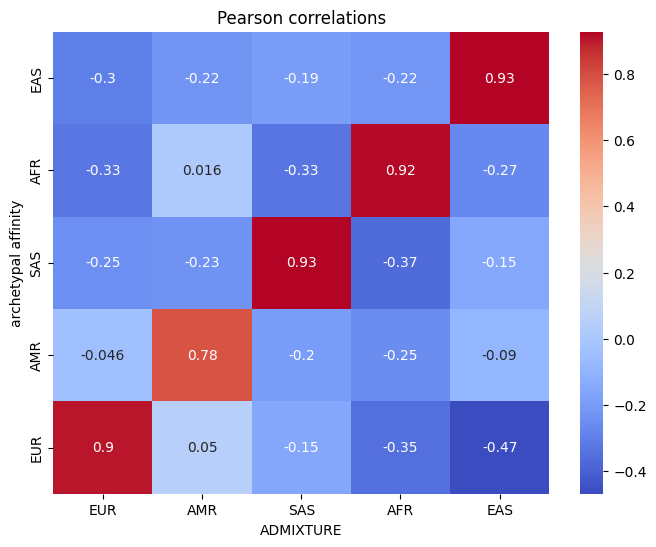

In [ ]:
# plot Pearson correlations confusion matrix
correlation_matrix = pd.DataFrame(
    [[admix_df[col1].corr(normalized_log_arr_df[col2]) for col2 in normalized_log_arr_df.columns] for col1 in admix_df.columns],
    index=admix_df.columns, columns=normalized_log_arr_df.columns
)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.iloc[::-1], annot=True, cmap='coolwarm', cbar=True)
plt.title('Pearson correlations')
plt.xlabel('ADMIXTURE')
plt.ylabel('archetypal affinity')
plt.show()

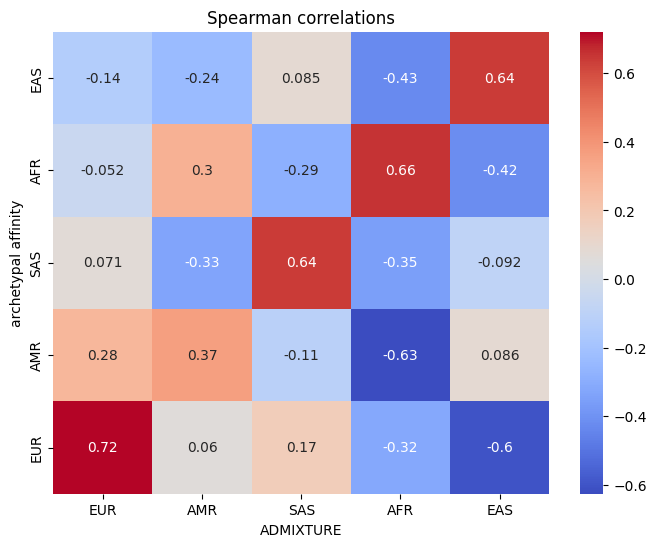

In [ ]:
# plot Spearman correlations confusion matrix
correlation_matrix = pd.DataFrame(
    [[admix_df[col1].corr(normalized_log_arr_df[col2], method='spearman') for col2 in normalized_log_arr_df.columns] for col1 in admix_df.columns],
    index=admix_df.columns, columns=normalized_log_arr_df.columns
)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.iloc[::-1], annot=True, cmap='coolwarm', cbar=True)
plt.title('Spearman correlations')
plt.xlabel('ADMIXTURE')
plt.ylabel('archetypal affinity')
plt.show()

# PCA + AAnet

In [58]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(data)

In [59]:
# initial phate embedding
phate_operator_2d = phate.PHATE(random_state=42, 
                                n_components=2, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_2d.fit(pca_input)
phate_emb_2d = phate_operator_2d.transform()

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 1.25 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.28 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.80 seconds.
Calculated landmark operator in 4.21 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.43 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.49 seconds.


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap=mappings.pop_pallette_1000G_fine, c=label_pop,
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title='1000G population', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)

ValueError: Expected c of length 3449 or 1. Got 2504

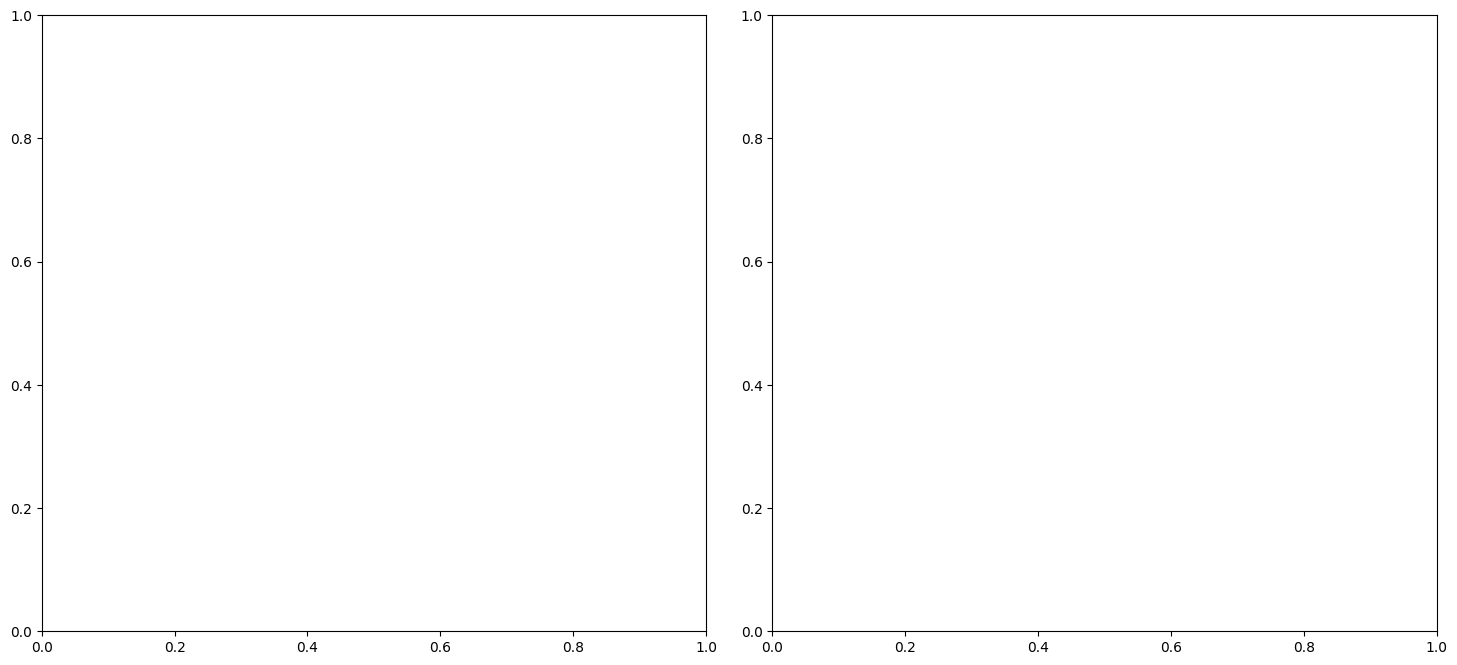

In [60]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap=mappings.pop_pallette_1000G_fine, c=label_pop,
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title='1000G population', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)

In [53]:
pca_input_norm = pca_input / np.std(pca_input[:, 0])
# density subsampling
distances, _ = sklearn.neighbors.NearestNeighbors(n_neighbors=1000).fit(pca_input_norm).kneighbors()
distances = distances.max(axis=1)
p = distances / distances.sum()
X_subsample = scprep.select.select_rows(pca_input_norm, idx=np.random.choice(pca_input_norm.shape[0],
                                                                int(pca_input_norm.shape[0]/2), p=p, replace=False))


In [55]:
# Optionally, warm-start model with graph-based extrema
N_ARCHETYPES = 5
extrema_idx = torch.Tensor(utils.get_laplacian_extrema(X_subsample, n_extrema=N_ARCHETYPES, knn=100, subsample=True))
extrema = torch.Tensor(X_subsample[extrema_idx.numpy().astype(int)])

NetworkXError: graph is not connected.

In [ ]:
# visualize the extrema
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=ax,
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d[extrema_idx.numpy().astype(int)], s=100, c='black', ax=ax)

In [ ]:
device = torch.device("cpu")
data_loader = torch.utils.data.DataLoader(pca_input, batch_size=256, shuffle=True, num_workers=4)